## Titanic:  MLP (Keras) vs LightGBM vs CatBoost vs XGBoost with same features

In [2]:
from math import *
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import Imputer, StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.python.client import device_lib

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

print(device_lib.list_local_devices())

config = tf.ConfigProto(device_count={"CPU": 1, "GPU" : 1})
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2956380693436829060
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4943878553
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3464432984791452240
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [3]:
test = pd.read_csv(r"c:\work\dataset\titanic\test.csv", ",")
train = pd.read_csv(r"c:\work\dataset\titanic\train.csv", ",")
#test = pd.read_csv("../input/test.csv", ",")
#train = pd.read_csv("../input/train.csv", ",")
test["is_test"] = True
train["is_test"] = False
common = pd.concat([test, train],axis=0).loc[:,["PassengerId", "Survived", "is_test", 
                                                "Age", "Cabin", "Embarked", 
                                                "Fare", "Name", "Parch", "Pclass", 
                                                "Sex", "SibSp", "Ticket"]]

### Feature engineering
Ticket based features:

In [4]:
common["Ticket"].count() - len(common["Ticket"].unique())

380

Ticket has repeated values, so use grouping. We can get number of passengers per ticket and number/percent of females per single ticket. Also ticket can be pure digital or with some text info.

In [5]:
t = train.groupby(by="Ticket", as_index=False).agg({"PassengerId" : 'count', "Sex" : lambda x : x[x=="female"].count()})
t.columns = ["Ticket", "SameTicket", "FemalesOnTicket"]
common = pd.merge(common, t, how="left", on="Ticket")

common["TicketDigits"] = pd.to_numeric(common["Ticket"].str.split(" ").str[-1], errors="coerce").astype(np.str).str.len()
common["TicketIsNumber"] = ~common["Ticket"].str.contains("[A-Za-z]", regex = True)
common["FemalesPerTicketPart"] = common["FemalesOnTicket"]/common["SameTicket"]

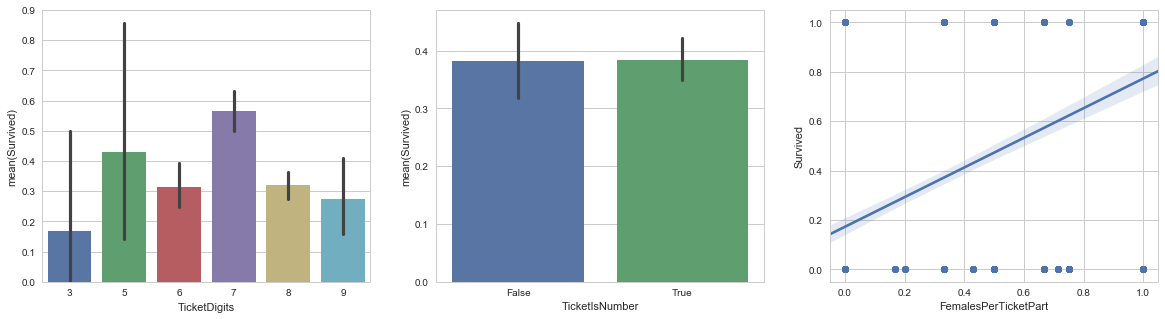

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="TicketDigits", y="Survived", data=common, ax=ax[0])
sns.barplot(x="TicketIsNumber", y="Survived", data=common, ax = ax[1])
sns.regplot(x="FemalesPerTicketPart", y="Survived", data=common, ax = ax[2])
plt.show();

TicketIsNumber seems to be not valued

Now process Name field. Some records have two passengers in single field name. 

In [7]:
common["DoubleName"] = common["Name"].str.contains("\(")
common["NameLen"] = common["Name"].str.len()

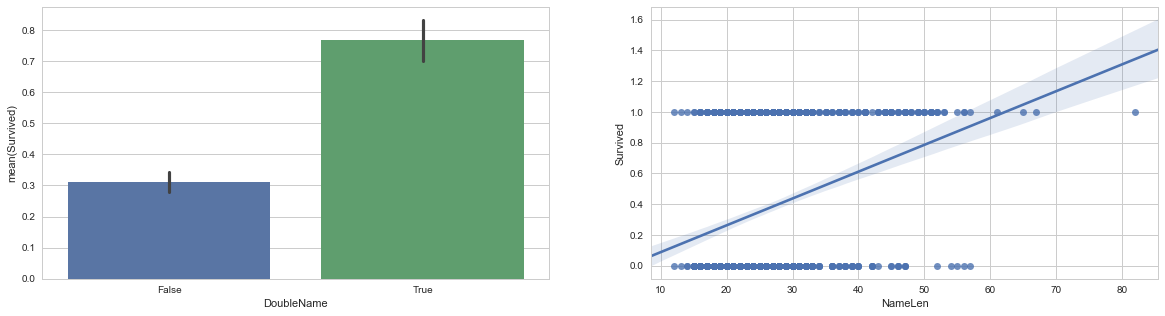

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x="DoubleName", y="Survived", data=common, ax=ax[0])
sns.regplot(x="NameLen", y="Survived", data=common, ax = ax[1])
plt.show();

Get title from Name, and average survivability per title

In [9]:
common["Title"] = common["Name"].str.split(", ").str[1].str.split(" ").str[0]
common.loc[common["Title"].str[-1]!=".", "Title"]="Bad"
rare_title = common["Title"].value_counts()[common["Title"].value_counts() < 5].index
common["Title"] = common["Title"].apply(lambda x: 'Rare' if x in rare_title else x)

titletarget = common.groupby(by="Title", as_index=False).agg({"Survived" : 'mean'})
titletarget.columns = ["Title", "TargetByTitle"]
common = pd.merge(common, titletarget, how="left", on="Title")

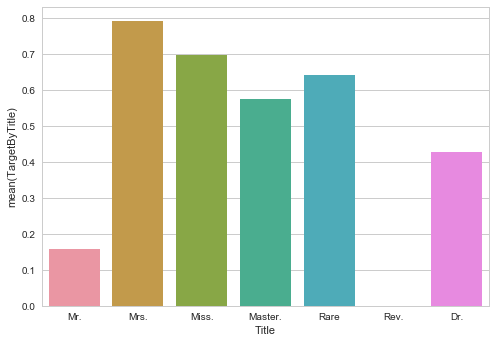

In [10]:
sns.barplot(x="Title", y="TargetByTitle", data=common)
plt.show()

Make features related to family size

In [11]:
common["Family"] = common["Parch"] + common["SibSp"] + 1
common["Alone"] = common["Family"] == 1

Process cabin number, get deck (vertical coordinate in ship), cabin digit number as distance from ship's nose, and check is number odd/even as side of ship axis. Also we can get average survivability per deck.

In [12]:
cap = train.groupby(by="Cabin", as_index=False).agg({"PassengerId" : 'count'})
cap.columns = ["Cabin", "SameCabin"]
common = pd.merge(common, cap, how="left", on="Cabin")
common["CabinNumber"] = pd.to_numeric(common["Cabin"].str[1:], errors = "coerce")
common["CabinEven"] = common["CabinNumber"] %2
common["CabinsPerMan"] = common["Cabin"].str.split(" ").str.len()
common["Deck"] = common["Cabin"].str[0].rank().fillna(-1)

decktarget = common.groupby(by="Deck", as_index=False).agg({"Survived" : 'mean'})
decktarget.columns = ["Deck", "TargetByDeck"]
common = pd.merge(common, decktarget, how="left", on="Deck")

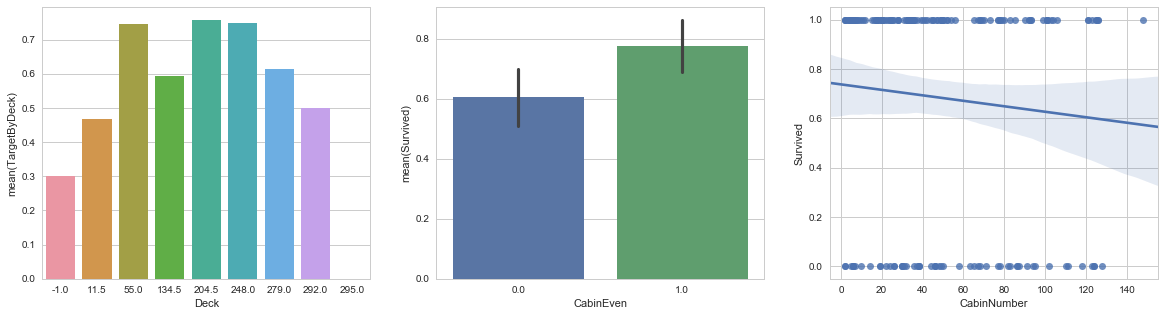

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="Deck", y="TargetByDeck", data=common.sort_values("Deck"), ax=ax[0])
sns.barplot(x="CabinEven", y="Survived", data=common, ax=ax[1])
sns.regplot(x="CabinNumber", y="Survived", data=common, ax=ax[2])

plt.show()

Now process age field. We can split it on ranges and get average survivality per one. Also calculate average age of family.

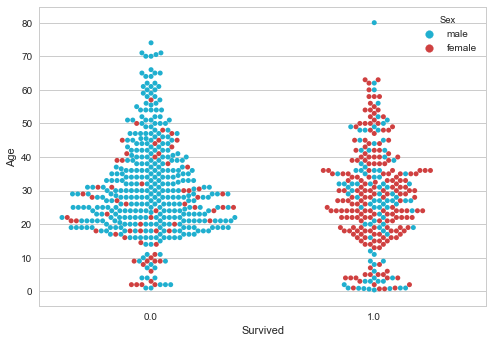

In [14]:
sns.swarmplot(x="Survived", y="Age", hue="Sex", palette=sns.color_palette(["#20AFCF","#cf4040"]), data=common)
plt.show()

In [15]:
common['AgeGroup'] = pd.qcut(common['Age'].fillna(common['Age'].mean()).astype(int), 6)
agetarget = common.groupby(by="AgeGroup", as_index=False).agg({"Survived" : 'mean'})
agetarget.columns = ["AgeGroup", "TargetByAgeGroup"]
common = pd.merge(common, agetarget, how="left", on="AgeGroup")

common["IsTinyChild"] = common["Age"]<1
common["IsChild"] = common["Age"]<10
common["AverageAge"] = common["Age"] / common["Family"]

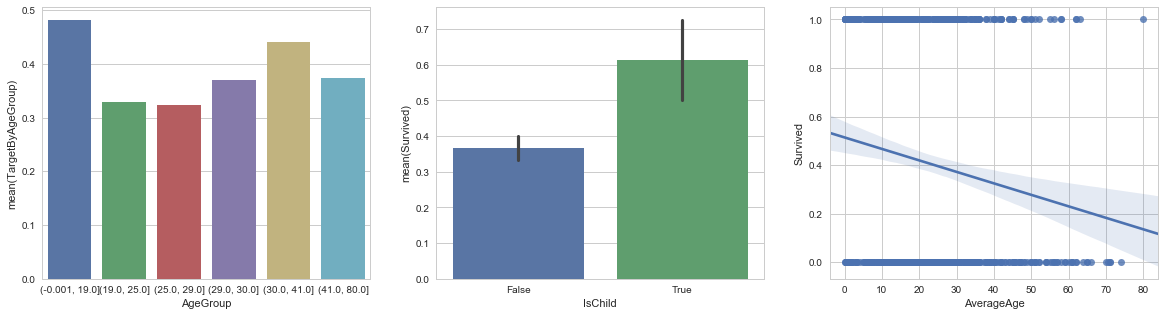

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="AgeGroup", y="TargetByAgeGroup", data=common, ax = ax[0])
sns.barplot(x="IsChild", y="Survived", data=common, ax = ax[1])
sns.regplot(x="AverageAge", y="Survived", data=common, ax = ax[2])
plt.show();

Fare processing. We also can split it on ranges and get survivability per fare range. 

In [17]:
common['FareGroup'] = pd.qcut(common['Fare'].fillna(common['Fare'].mean()).astype(int), 6)
faretarget = common.groupby(by="FareGroup", as_index=False).agg({"Survived" : 'mean'})
faretarget.columns = ["FareGroup", "TargetByFareGroup"]
common = pd.merge(common, faretarget, how="left", on="FareGroup")
common["AverageFareByFamily"] = common["Fare"] / common["Family"]
common["AverageFareByTicket"] = common["Fare"] / common["SameTicket"]
common["FareLog"] = np.log(common["Fare"])

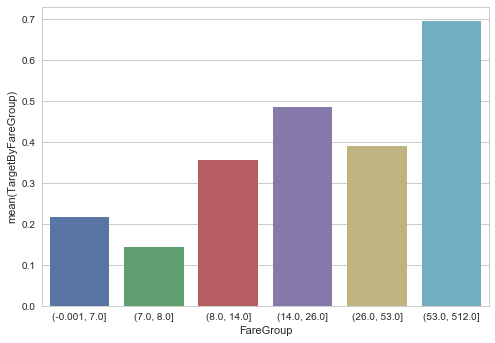

In [18]:
sns.barplot(x="FareGroup", y="TargetByFareGroup", data=common)
plt.show()

Now calculate average survivability for each left categorical fields

In [19]:
pclasstarget = common.groupby(by="Pclass", as_index=False).agg({"Survived" : 'mean'})
pclasstarget.columns = ["Pclass", "TargetByPclass"]
common = pd.merge(common, pclasstarget, how="left", on="Pclass")

Embarkedtarget = common.groupby(by="Embarked", as_index=False).agg({"Survived" : 'mean'})
Embarkedtarget.columns = ["Embarked", "TargetByEmbarked"]
common = pd.merge(common, Embarkedtarget, how="left", on="Embarked")

Sextarget = common.groupby(by="Sex", as_index=False).agg({"Survived" : 'mean'})
Sextarget.columns = ["Sex", "TargetBySex"]
common = pd.merge(common, Sextarget, how="left", on="Sex")

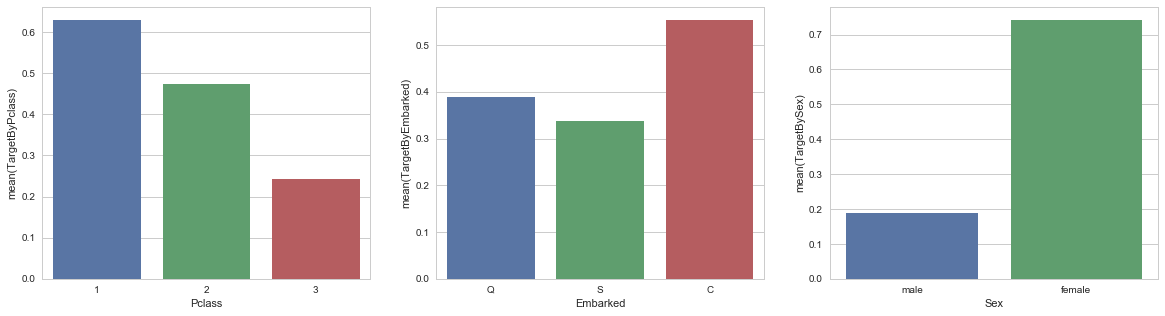

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.barplot(x="Pclass", y="TargetByPclass", data=common, ax=ax[0])
sns.barplot(x="Embarked", y="TargetByEmbarked", data=common, ax = ax[1])
sns.barplot(x="Sex", y="TargetBySex", data=common, ax = ax[2])
plt.show();

### Feature selection and preprocessing

In [21]:
allfeatures = [
    "PassengerId", 
    "is_test", 
    "Survived", 
    "Age", 
    "Fare", 
    "Parch", 
    "Pclass",
    "SibSp", 
    "Sex", 
    "Embarked", 
    "SameTicket", 
    "FemalesOnTicket", 
    "SameCabin", 
    "Deck", 
    "TargetByDeck", 
    "TargetByTitle", 
    "TargetByAgeGroup", 
    "TargetByFareGroup",
    "TargetByPclass",
    "TargetByEmbarked",
    "TargetBySex",
    "Title", 
    "CabinNumber", 
    "CabinEven", 
    "CabinsPerMan", 
    "DoubleName", 
    "NameLen", 
    "TicketDigits",
    "TicketIsNumber",
    "IsTinyChild", 
    "IsChild", 
    "Alone", 
    "Family", 
    "AverageAge",
    "AverageFareByFamily",
    "AverageFareByTicket",
    "FemalesPerTicketPart"
]

c = common.loc[:, allfeatures]
c = pd.get_dummies(c, columns=[
    "Title", 
    "Embarked", 
    "Pclass",
    "Sex"
])

In [22]:
c.describe().T.sort_values("count")

,count,mean,std,min,25%,50%,75%,max
CabinNumber,248.0,49.379032,35.444909,2.000000,22.000000,38.500000,78.000000,148.000000
CabinEven,248.0,0.451613,0.498660,0.000000,0.000000,0.000000,1.000000,1.000000
SameCabin,249.0,1.674699,0.858192,1.000000,1.000000,1.000000,2.000000,4.000000
CabinsPerMan,295.0,1.206780,0.578487,1.000000,1.000000,1.000000,1.000000,4.000000
Survived,891.0,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
SameTicket,1043.0,1.812081,1.378881,1.000000,1.000000,1.000000,2.000000,7.000000
FemalesOnTicket,1043.0,0.767977,0.959772,0.000000,0.000000,0.000000,1.000000,5.000000
AverageFareByTicket,1043.0,21.566098,28.633854,0.000000,7.816667,10.287500,26.000000,221.779200
FemalesPerTicketPart,1043.0,0.375917,0.418706,0.000000,0.000000,0.000000,0.750000,1.000000
AverageAge,1046.0,22.609517,14.643413,0.042500,12.000000,21.166667,30.000000,80.000000


Several features requires imputation and normalization

In [23]:
c.iloc[:,3:] = Imputer(strategy="most_frequent").fit_transform(c.iloc[:,3:])

dep = c[c["is_test"] == False].loc[:, ["Survived"]]
indep = c[c["is_test"] == False].iloc[:, 3:]
res = c[c["is_test"] == True].iloc[:, 3:]
res_index = c[c["is_test"] == True].loc[:, "PassengerId"]

indep.iloc[:,3:] = StandardScaler().fit_transform(indep.iloc[:,3:])
res.iloc[:,3:] = StandardScaler().fit_transform(res.iloc[:,3:])

indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=47)

### Model 1. Keras MLP
Make simple sequental MLP NN. (Parameters selected manually)

In [1]:
with tf.device('/device:CPU:0'):
    gs1 = Sequential()
    gs1.add(Dense(45 ,activation='linear', input_dim=45))
    gs1.add(BatchNormalization())

    gs1.add(Dense(9,activation='linear'))
    gs1.add(BatchNormalization())
    gs1.add(Dropout(0.4))

    gs1.add(Dense(5,activation='linear'))
    gs1.add(BatchNormalization())
    gs1.add(Dropout(0.2))

    gs1.add(Dense(1,activation='relu', ))
    gs1.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0), loss='binary_crossentropy', metrics=['accuracy'])

    gs1.fit(indep_train, dep_train, epochs=500, batch_size=30, validation_data=(indep_test,dep_test), verbose=False)
    g=gs1.predict_classes(res)[:,0]
    print(accuracy_score(dep_test, gs1.predict_classes(indep_test)), accuracy_score(dep_train, gs1.predict_classes(indep_train)))

NameError: name 'tf' is not defined

Lets see how accuracy changes during epochs

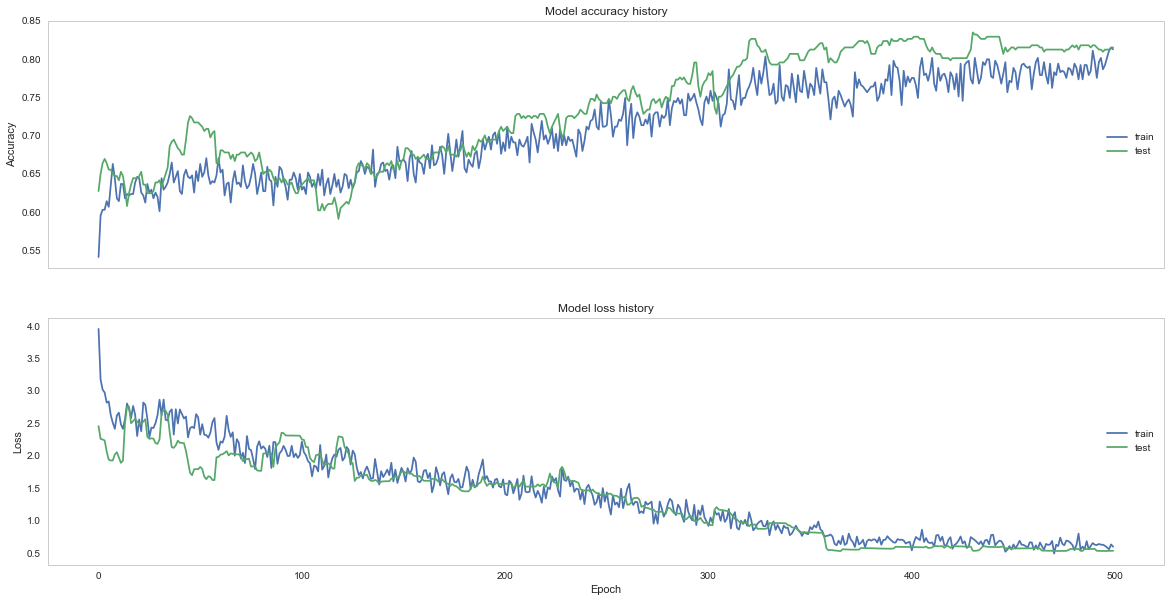

In [24]:
fig, ax = plt.subplots(2, 1, sharex='col', figsize=(20, 10))
ax[0].set_title('Model accuracy history')
ax[0].plot(gs1.history.history['acc'])
ax[0].plot(gs1.history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc='right')
ax[0].grid()

ax[1].set_title('Model loss history')
ax[1].plot(gs1.history.history['loss'])
ax[1].plot(gs1.history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc='right')
ax[1].grid()
plt.xlabel('Epoch')
plt.show()

Get same NN on 5 folds and average result

In [25]:
cvscores = []
data = pd.DataFrame()
i=1
with tf.device('/device:CPU:0'):
    for train, test in StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(indep, dep.iloc[:,0]):
        X = indep.reindex().iloc[train,:]
        Y = dep.reindex().iloc[train,0]
        Xv = indep.reindex().iloc[test,:]
        Yv = dep.reindex().iloc[test,0]
        
        gs1 = Sequential()
        gs1.add(Dense(45 ,activation='linear', input_dim=45))
        gs1.add(BatchNormalization())

        gs1.add(Dense(9,activation='linear'))
        gs1.add(BatchNormalization())
        gs1.add(Dropout(0.4))

        gs1.add(Dense(5,activation='linear'))
        gs1.add(BatchNormalization())
        gs1.add(Dropout(0.2))

        gs1.add(Dense(1,activation='relu', ))
        gs1.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0), loss='binary_crossentropy', metrics=['accuracy'])

        gs1.fit(X, Y, epochs=500, batch_size=30, validation_data=(Xv, Yv), verbose=False)
        data[i] = gs1.predict_classes(res)[:,0]
        scores = gs1.evaluate(Xv, Yv, verbose=0)
        print(gs1.metrics_names[1], scores[1])
        cvscores.append(scores[1])
        i+=1
mlp_mean = np.mean(cvscores)
mlp_stdev = np.std(cvscores)
print(mlp_mean, mlp_stdev)

g = np.round(data.mean(axis=1))

acc 0.8435754179954529
acc 0.8212290532762112
acc 0.8033707838379935
acc 0.7752808995461196
acc 0.8474576277921428
0.818182756489584 0.026724704433442048


In [26]:
result = pd.DataFrame(res_index.astype(np.int), columns=["PassengerId"])
result["Survived"] = g.astype(np.int)
result.to_csv(r"c:\work\dataset\titanic\mlp.csv", ",", index=None)
result.to_csv("mlp.csv", ",", index=None)

Unfortunatelly, accuracy on LB too low (0.75119 - 0.79425 with different seeds)

### Model 2. LightGBM
All parameters selected by brute force, sequentally by 1-2 parameters. No HyperOpt nor GridSearchCV geven such accuracy for me.

In [24]:
# Example of manual parameter tuning
"""
for i in range(1,10):
    params = {}
    params["max_depth"] = i
    params["learning_rate"] = 0.45
    params["lambda_l1"] = 0.1
    params["lambda_l2"] = 0.01
    params["n_estimators"] = 5000
    params["n_jobs"]=5 
    params["objective"] = "binary"
    
    params["boosting"] = "dart"
    params["colsample_bytree"] = 0.9
    params["subsample"] =0.9

    train_data = lgb.Dataset(data=indep_train, label=dep_train, free_raw_data=False, feature_name = list(indep_train))
    cv_result = lgb.cv(params, train_data, nfold=5, stratified=False, metrics=['binary_error'], early_stopping_rounds=50)
    print(i, 1-np.mean(cv_result["binary_error-mean"]))
    """;

In [25]:
indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=47)
gs1 = lgb.LGBMClassifier(max_depth = 7,
                         lambda_l1 = 0.1,
                         lambda_l2 = 0.01,
                         learning_rate = 0.01, 
                         n_estimators = 500, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                         n_jobs = 5)
gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)], eval_metric='accuracy', verbose=False, early_stopping_rounds=50);



g = gs1.predict(res)
a = accuracy_score(dep_test, gs1.predict(indep_test))
b = accuracy_score(dep_train, gs1.predict(indep_train))
print(a, b)

0.8151260504201681 0.9194756554307116


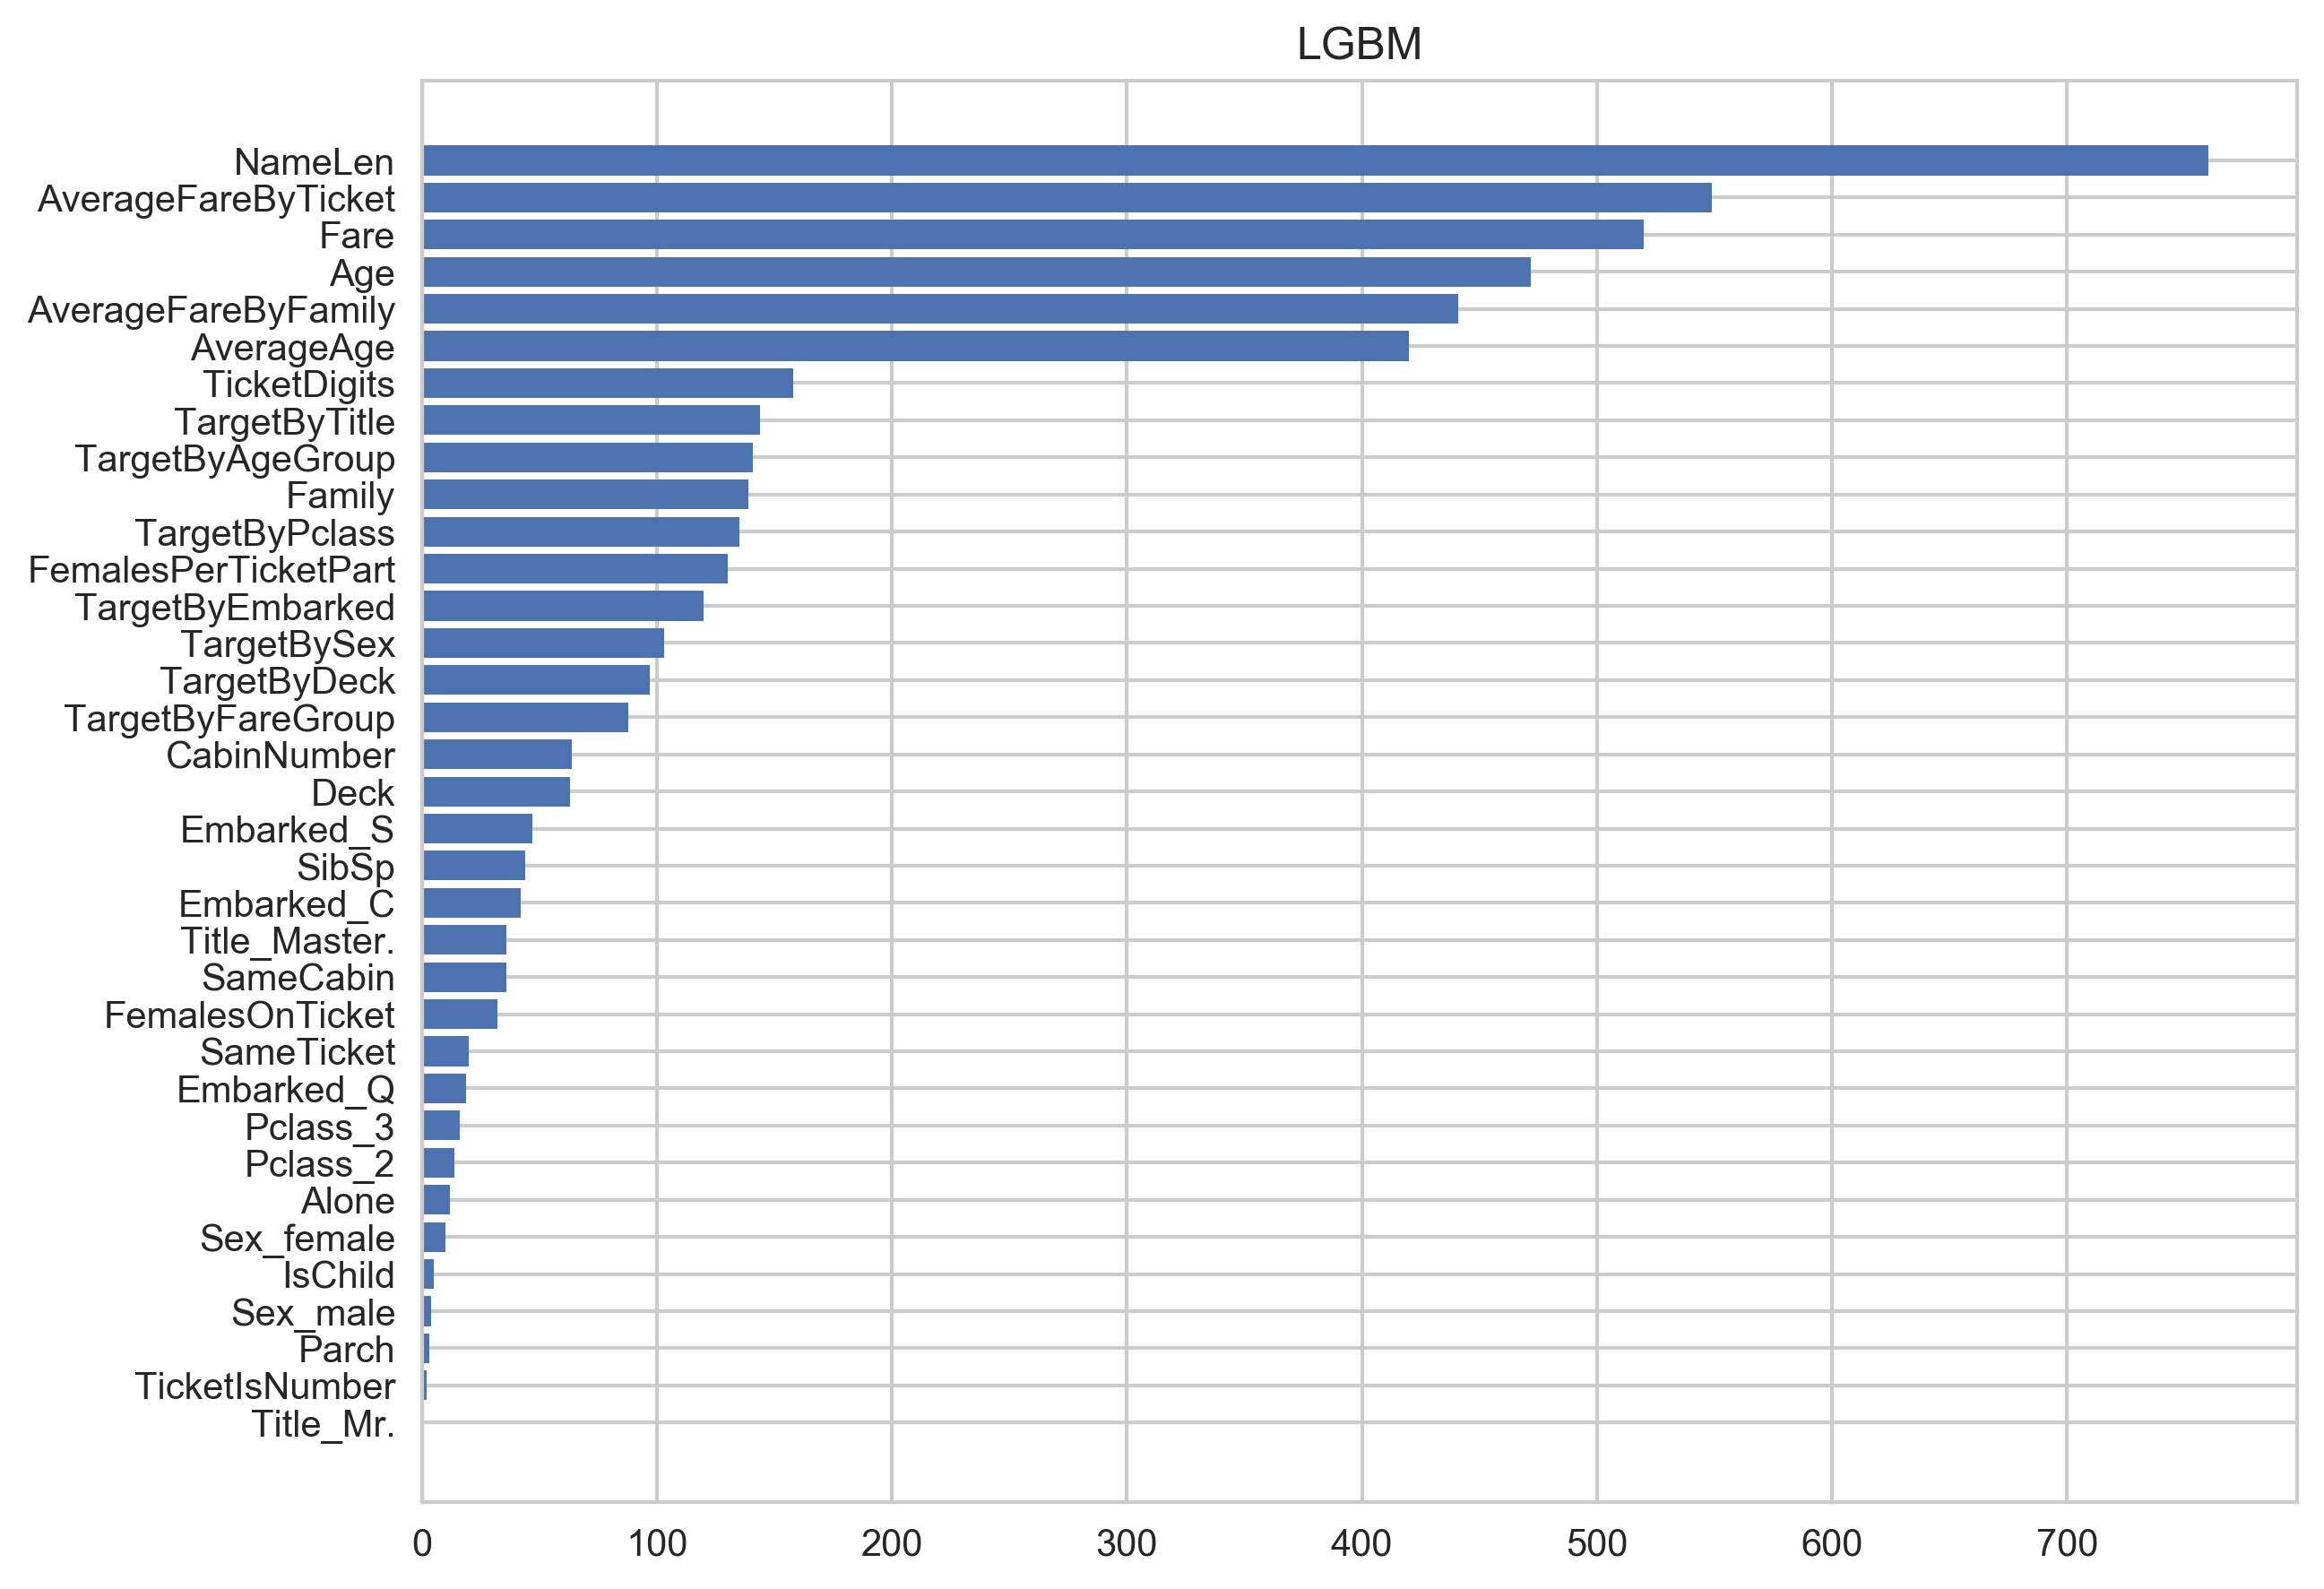

In [26]:
attr2 = {k: v for k, v in zip(indep.columns, gs1.feature_importances_) if v>0}
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = False)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(9, 7), dpi=300, facecolor='w', edgecolor='k')
plt.barh(i1, y1)
plt.title("LGBM")
plt.yticks(i1, x1)
plt.show();

Now blend results of models with different seeds (i experimentally got optimal number of models - 90)

In [27]:
model = []
cvscores = []

for i in range(0,90):
    indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=i)
    gs1 = lgb.LGBMClassifier(max_depth = 7,
                             lambda_l1 = 0.1,
                             lambda_l2 = 0.01,
                             learning_rate =  0.01, num_iterations=20000,
                             n_estimators = 5000, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                             n_jobs = 5, boosting='dart' )
    gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)], eval_metric='accuracy', verbose=False, early_stopping_rounds=50);
    model.append(gs1)
    cvscores.append(accuracy_score(dep_test, gs1.predict(indep_test)))

data = pd.DataFrame()
te = pd.DataFrame()
for i in range(0,90):
    data[i] = model[i].predict(res)
    te[i] = model[i].predict(indep_test)

g = np.round(data.mean(axis=1))
t = np.round(te.mean(axis=1))

lgb_mean = np.mean(cvscores)
lgb_stdev = np.std(cvscores)
print(lgb_mean, lgb_stdev)

0.8259570494864612 0.0190036291065674


This got <b>0.82296</b> on LB

In [ ]:
result = pd.DataFrame(res_index.astype(np.int), columns=["PassengerId"])
result["Survived"] = g.astype(np.int)
result.to_csv(r"c:\work\dataset\titanic\lgbm.csv", ",", index=None)
result.to_csv("lgbm.csv", ",", index=None)

### Model 3. CatBoost
Same approach

In [ ]:
gs1 = cb.CatBoostClassifier(depth = 9, reg_lambda=0.1,
                         learning_rate = 0.09, 
                         iterations = 500)
gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)],  verbose=False, early_stopping_rounds=50);

g = gs1.predict(res)
a = accuracy_score(dep_test, gs1.predict(indep_test))
b = accuracy_score(dep_train, gs1.predict(indep_train))
#cv = cross_val_score(gs1, indep_train, dep_train, cv=5)
print(a, b)

In [ ]:
attr2 = {k: v for k, v in zip(indep.columns, gs1.feature_importances_) if v>0}
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = False)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(9, 8), dpi=300, facecolor='w', edgecolor='k')
plt.barh(i1, y1)
plt.title("CatBoost")
plt.yticks(i1, x1)
plt.show();

In [ ]:
model = []
cvscores = []
for i in range(0, 90):
    indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=i)
    gs1 = cb.CatBoostClassifier(depth = 9, reg_lambda=0.1,
                     learning_rate = 0.09, 
                     iterations = 500)
    gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)],  verbose=False, early_stopping_rounds=50);
    model.append(gs1)
    cvscores.append(accuracy_score(dep_test, gs1.predict(indep_test)))
    
data = pd.DataFrame()
te = pd.DataFrame()

for i in range(0, 90):
    data[i] = model[i].predict(res)
    te[i] = model[i].predict(indep_test)

g = np.round(data.mean(axis=1))
t = np.round(te.mean(axis=1))

cb_mean = np.mean(cvscores)
cb_stdev = np.std(cvscores)
print(cb_mean, cb_stdev)


In [ ]:
result = pd.DataFrame(res_index.astype(np.int), columns=["PassengerId"])
result["Survived"] = g.astype(np.int)
result.to_csv(r"c:\work\dataset\titanic\catboost.csv", ",", index=None)
result.to_csv("catboost.csv", ",", index=None)

### Model 4. XGBoost

In [ ]:
gs1 = xgb.XGBClassifier(max_depth = 9,
                         learning_rate = 0.01, 
                         n_estimators = 500, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                         n_jobs = 5)
gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)],  verbose=False, early_stopping_rounds=50);

g = gs1.predict(res)
a = accuracy_score(dep_test, gs1.predict(indep_test))
b = accuracy_score(dep_train, gs1.predict(indep_train))
print(a, b)

In [ ]:
attr2 = {k: v for k, v in zip(indep.columns, gs1.feature_importances_) if v>0}
attr2 = sorted(attr2.items(), key=lambda x: x[1], reverse = False)
x1,y1 = zip(*attr2)
i1=range(len(x1))
plt.figure(num=None, figsize=(9, 7), dpi=300, facecolor='w', edgecolor='k')
plt.barh(i1, y1)
plt.title("XGBoost")
plt.yticks(i1, x1)
plt.show();

In [ ]:
model = []
cvscores = []
for i in range(0, 90):
    indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size=0.40, random_state=i)
    gs1 = xgb.XGBClassifier(max_depth = 7, reg_lambda = 0.02,
                         learning_rate = 0.01, 
                         n_estimators = 5000, reg_alpha = 1.1, colsample_bytree = 0.9, subsample = 0.9,
                         n_jobs = 5)
    gs1.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)],  verbose=False, early_stopping_rounds=50);
    model.append(gs1)
    cvscores.append(accuracy_score(dep_test, gs1.predict(indep_test)))
    
data = pd.DataFrame()
te = pd.DataFrame()

for i in range(0, 90):
    data[i] = model[i].predict(res)
    te[i] = model[i].predict(indep_test)

g = np.round(data.mean(axis=1))
t = np.round(te.mean(axis=1))

xgb_mean = np.mean(cvscores)
xgb_stdev = np.std(cvscores)
print(xgb_mean, xgb_stdev)

In [ ]:
result = pd.DataFrame(res_index.astype(np.int), columns=["PassengerId"])
result["Survived"] = g.astype(np.int)
result.to_csv(r"c:\work\dataset\titanic\xgb.csv", ",", index=None)
result.to_csv("lgbm.csv", ",", index=None)

In [ ]:
d = {'Model':["Keras MLP", "LightGBM", "CatBoost", "XGBoost"], 
     'Mean accuracy': [mlp_mean, lgb_mean, cb_mean, xgb_mean], 
     'Std. Dev.': [mlp_stdev, lgb_stdev, cb_stdev, xgb_stdev],
    'Leaderboard': [0.77033, 0.82296, 0.78947, 0.77511]}
pd.DataFrame(data=d, columns=["Model", "Mean accuracy", "Std. Dev.", "Leaderboard"]).sort_values("Mean accuracy", ascending=False).head(10)

In [31]:
indep.columns

Index(['Age', 'Fare', 'Parch', 'SibSp', 'SameTicket', 'FemalesOnTicket',
       'SameCabin', 'Deck', 'TargetByDeck', 'TargetByTitle',
       'TargetByAgeGroup', 'TargetByFareGroup', 'TargetByPclass',
       'TargetByEmbarked', 'TargetBySex', 'CabinNumber', 'CabinEven',
       'CabinsPerMan', 'DoubleName', 'NameLen', 'TicketDigits',
       'TicketIsNumber', 'IsTinyChild', 'IsChild', 'Alone', 'Family',
       'AverageAge', 'AverageFareByFamily', 'AverageFareByTicket',
       'FemalesPerTicketPart', 'Title_Dr.', 'Title_Master.', 'Title_Miss.',
       'Title_Mr.', 'Title_Mrs.', 'Title_Rare', 'Title_Rev.', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')